# WIP Data augmentation 


In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf


import pathlib
import pandas as pd

import pydicom # for DICOM images
from skimage.transform import resize

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
print(tf.__version__)

2.6.0


In [3]:
def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

In [4]:
# Directory
directory = '/Users/renau/Desktop/DATA/data_proj_melanoma'

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

# Change columns names
new_names = ['dcm_name', 'ID', 'sex', 'age', 'anatomy', 'diagnosis', 'benign_malignant', 'target']
train_df.columns = new_names
test_df.columns = new_names[:5]

Train has 33,126 rows and Test has 10,982 rows.


In [5]:
# === JPEG ===
# Create the paths
path_train = directory + '/jpeg/train/' + train_df['dcm_name'] + '.jpg'
path_test = directory + '/jpeg/test/' + test_df['dcm_name'] + '.jpg'

# Append to the original dataframes
train_df['path_jpeg'] = path_train
test_df['path_jpeg'] = path_test

In [6]:
malignant_df = train_df[train_df['target'] == 1]
malignant_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
91,ISIC_0149568,IP_0962375,female,55.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
235,ISIC_0188432,IP_0135517,female,50.0,upper extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
314,ISIC_0207268,IP_7735373,male,55.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
399,ISIC_0232101,IP_8349964,male,65.0,torso,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
459,ISIC_0247330,IP_3232631,female,65.0,lower extremity,melanoma,malignant,1,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [7]:
benin_df = train_df[train_df['target'] == 0]
benin_df.head()

,dcm_name,ID,sex,age,anatomy,diagnosis,benign_malignant,target,path_jpeg
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,/Users/renau/Desktop/DATA/data_proj_melanoma/j...


In [8]:
mal_file = malignant_df['path_jpeg'].values
mal_labels = malignant_df['target'].values
mal_train_ds = tf.data.Dataset.from_tensor_slices((mal_file, mal_labels))
len(list(mal_train_ds))

584

In [9]:
ben_file = benin_df['path_jpeg'].values
ben_labels = benin_df['target'].values
ben_train_ds = tf.data.Dataset.from_tensor_slices((ben_file, ben_labels))
len(list(ben_train_ds))

32542

In [10]:
benPart_train_ds = ben_train_ds.take(len(list(mal_train_ds)))
#benPart_train_ds = ben_train_ds.take(15000)
len(list(benPart_train_ds))

584

In [11]:
train_ds = mal_train_ds.concatenate(benPart_train_ds)
#train_ds = ben_train_ds.take(1000)
shuf_train_ds = train_ds.shuffle(len(list(train_ds)))
len(list(shuf_train_ds))

1168

In [12]:
def make_balanced_dataset(ds_class1, ds_class2):
    half_size = min(len(list(ds_class1)),len(list(ds_class2)))
    ds_1 = ds_class1.take(half_size)
    ds_2 = ds_class2.take(half_size)
    ds_full = ds_1.concatenate(ds_2)
    ds_full = ds_full.shuffle(half_size*2, reshuffle_each_iteration=False)
    return ds_full.skip((half_size*2)//5),ds_full.take((half_size*2)//5),
#print(make_balanced_dataset(ben_train_ds,mal_train_ds))   
ds_train, ds_val = make_balanced_dataset(ben_train_ds,mal_train_ds)
size = len(list(ds_val))
print(size, len(list(ds_train)))

233 935


In [13]:
ex_ds = ds_train.take(4)
for element in ex_ds :
    print(element[0].numpy(),'and target: ',element[1].numpy())

b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0082934.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0599605.jpg' and target:  1
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_0249269.jpg' and target:  0
b'/Users/renau/Desktop/DATA/data_proj_melanoma/jpeg/train/ISIC_2937642.jpg' and target:  1


In [14]:
def read_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, dtype = tf.uint8, expand_animations = False)
    return image, label

ds_train = ds_train.map(read_image)
ds_val = ds_val.map(read_image)

In [15]:
ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].numpy().shape)

(4000, 6000, 3)
(2448, 3264, 3)
(4000, 6000, 3)


In [16]:
def adapt_data(image, label):
    image = tf.image.resize(image, [256,256])
    return image, label

def convert_to_float(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float64)
    return image, label
    
ds_train= ds_train.map(adapt_data).map(convert_to_float).batch(32)
ds_val= ds_val.map(adapt_data).map(convert_to_float).batch(32)

ex_ds = ds_train.take(3)
for element in ex_ds :
    print(element[0].shape)
    print(element[1].shape)

(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)
(32, 256, 256, 3)
(32,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.cache().prefetch(buffer_size=AUTOTUNE)
ds_val = ds_val.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

model = tf.keras.Sequential([ 
    
#==Data Augment==
    
    preprocessing.RandomContrast(factor=0.1),
    preprocessing.RandomFlip(mode='horizontal'), 
    preprocessing.RandomFlip(mode='vertical'), 
    preprocessing.RandomRotation(factor=0.20),

#==CONV== 
    
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

#==HEAD==<
    layers.Flatten(),
    
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    #layers.BatchNormalization(),
    
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    #layers.BatchNormalization(),
    
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    #layers.BatchNormalization(),
    
    layers.Dense(1,activation='sigmoid')
])

In [27]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [28]:
history = model.fit(
    ds_train,
    validation_data=ds_val,
    epochs=150,
)

Epoch 1/150
30/30 [==============================] - 2s 42ms/step - loss: 0.6898 - binary_accuracy: 0.4941 - val_loss: 0.6813 - val_binary_accuracy: 0.5064
Epoch 2/150
30/30 [==============================] - 1s 39ms/step - loss: 0.6848 - binary_accuracy: 0.5198 - val_loss: 0.6724 - val_binary_accuracy: 0.5880
Epoch 3/150
30/30 [==============================] - 1s 39ms/step - loss: 0.6740 - binary_accuracy: 0.5668 - val_loss: 0.6569 - val_binary_accuracy: 0.6738
Epoch 4/150
30/30 [==============================] - 1s 39ms/step - loss: 0.6659 - binary_accuracy: 0.5850 - val_loss: 0.6785 - val_binary_accuracy: 0.6137
Epoch 5/150
30/30 [==============================] - 1s 39ms/step - loss: 0.6581 - binary_accuracy: 0.6128 - val_loss: 0.6302 - val_binary_accuracy: 0.6996
Epoch 6/150
30/30 [==============================] - 1s 39ms/step - loss: 0.6415 - binary_accuracy: 0.6578 - val_loss: 0.6061 - val_binary_accuracy: 0.7210
Epoch 7/150
30/30 [==============================] - 1s 39ms/ste

30/30 [==============================] - 1s 39ms/step - loss: 0.5257 - binary_accuracy: 0.7380 - val_loss: 0.5289 - val_binary_accuracy: 0.7339
Epoch 54/150
30/30 [==============================] - 1s 39ms/step - loss: 0.5079 - binary_accuracy: 0.7572 - val_loss: 0.4967 - val_binary_accuracy: 0.7682
Epoch 55/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4942 - binary_accuracy: 0.7497 - val_loss: 0.5086 - val_binary_accuracy: 0.7725
Epoch 56/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4860 - binary_accuracy: 0.7551 - val_loss: 0.4962 - val_binary_accuracy: 0.7811
Epoch 57/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4788 - binary_accuracy: 0.7658 - val_loss: 0.4840 - val_binary_accuracy: 0.7811
Epoch 58/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4898 - binary_accuracy: 0.7487 - val_loss: 0.5124 - val_binary_accuracy: 0.7811
Epoch 59/150
30/30 [==============================] - 1s 39ms/step - lo

30/30 [==============================] - 1s 39ms/step - loss: 0.4799 - binary_accuracy: 0.7626 - val_loss: 0.4980 - val_binary_accuracy: 0.7725
Epoch 106/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4538 - binary_accuracy: 0.7840 - val_loss: 0.4848 - val_binary_accuracy: 0.7940
Epoch 107/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4092 - binary_accuracy: 0.8096 - val_loss: 0.4922 - val_binary_accuracy: 0.7854
Epoch 108/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4119 - binary_accuracy: 0.8000 - val_loss: 0.4898 - val_binary_accuracy: 0.7940
Epoch 109/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4232 - binary_accuracy: 0.8032 - val_loss: 0.4728 - val_binary_accuracy: 0.7811
Epoch 110/150
30/30 [==============================] - 1s 39ms/step - loss: 0.4125 - binary_accuracy: 0.8032 - val_loss: 0.4686 - val_binary_accuracy: 0.7682
Epoch 111/150
30/30 [==============================] - 1s 39ms/ste

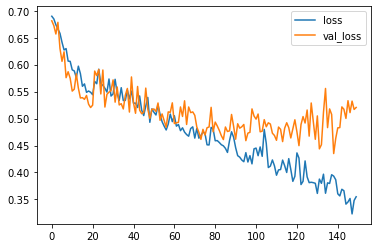

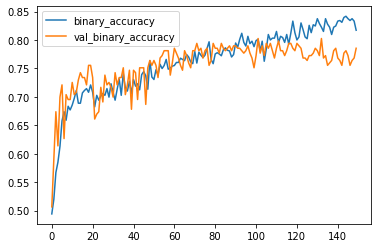

In [29]:
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot();

In [38]:
predictions = model.predict(ds_train)

b =0
m = 0
u = 0
for element in predictions :
    if(element[0] > 0.95) :
        m +=1
    elif(element[0]< 0.05) :
        b +=1
    else :
        u +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - doutes: ", u, "\n - Total comp: ", b+u+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  138 
 - Bénins:  261 
 - doutes:  536 
 - Total comp:  935  vs  935


In [36]:
predictions = model.predict(ds_val)

b =0
m = 0
for element in predictions :
    if(element[0] > 0.5) :
        m +=1
    elif(element[0]< 0.5) :
        b +=1
        
print("Prédictions ;\n - Malin(s): ", m, "\n - Bénins: ", b, "\n - Total comp: ", b+m," vs ",len(predictions))

Prédictions ;
 - Malin(s):  115 
 - Bénins:  118 
 - Total comp:  233  vs  233


In [32]:
from sklearn.metrics import plot_confusion_matrix  

def predict_class_label_number(dataset):
    predictions =  model.predict(dataset)
    res = np.zeros(len(predictions))
    i = 0 
    for element in predictions : 
        if(element[0]> 0.5):
            res[i] = 1
        i += 1
    return tf.convert_to_tensor(res)

def give_labels (dataset, size):
    lab = np.zeros(size)
    i = 0
    for batch in dataset:
        for element in batch[1] :
            lab[i] = element.numpy()
            i +=1
    return tf.convert_to_tensor(lab)
    
def show_confusion_matrix(cm, labels):
    plt.figure(figsize=(5,5))
    plt.imshow(cm)
    plt.colorbar()
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

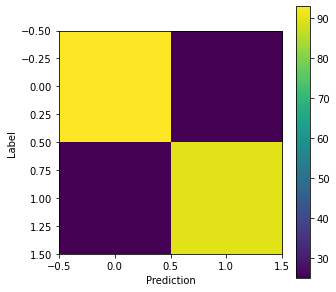

In [33]:
dataset = ds_val
#size = define upper bcs easier
confusion_mtx = tf.math.confusion_matrix(
    give_labels(dataset, size),
    predict_class_label_number(dataset),
    num_classes=2)
show_confusion_matrix(confusion_mtx, [0,1])